### Dataset

**No**: Jedinstveni ID sadnice  
**Plot**: Broj glavnog polja u kojem je sadnica zasađena (1-18)  
**Subplot**: Podpolje unutar glavnog polja gde je sadnica zasađena (A-E, 5 podpolja po uglovima + 1 u sredini)  
**Species**: Vrsta sadnice (Acer saccharum, Prunus serotina, Quercus alba, Quercus rubra)  
**Light_ISF**: Nivo svetlosti izmeren HemiView softverom, predstavlja količinu svetlosti na visini od 1m  
**Light_Cat**: Kategorijski nivo svetlosti kreiran deljenjem Light_ISF na tri bin-a (low, med, high)  
**Core**: Godina kada je zemljišni uzorak (soil core) uklonjen sa polja  
**Soil**: Vrsta sa koje je zemljišni uzorak uzet, uključuje sve vrste plus Acer rubrum, Populus grandidentata, sterilizovani konspecifični uzorak  
**Adult**: Pojedinačno drvo sa kojeg je uzet zemljišni uzorak, do 6 odraslih po vrsti (random effect u analizama)  
**Sterile**: Da li je zemljište sterilizovano ili ne  
**Conspecific**: Da li je zemljište konspecifično, heterospecifično ili sterilizovano konspecifično  
**Myco**: Mikorizni tip sadnice (AMF ili EMF)  
**SoilMyco**: Mikorizni tip vrste koja je kultivisala zemljište (AMF ili EMF)  
**PlantDate**: Datum kada je sadnica posađena u polje  
**AMF**: Procenat kolonizacije arbuskularnom mikorizom (AMF) na finim korenima  
**EMF**: Procenat kolonizacije ektomikorizom (EMF) na vrhovima korena  
**Phenolics**: Izračunato kao nmol ekvivalenta galne kiseline po mg suvog ekstrakta  
**NSC**: Procenat nerastvornih ugljenih hidrata (dry mass NSC)  
**Lignin**: Procenat lignina u suvoj masi  
**Census**: Broj popisa kada je sadnica umrla ili je ubrana  
**Time**: Broj dana kada je sadnica umrla ili ubrana  
**Event**: Status sadnice u datom trenutku za survival analizu (0 = ubrano ili kraj eksperimenta, 1 = mrtvo)  
**Harvest**: Da li je sadnica ubrana za merenje osobina  
**Alive**: Da li je sadnica živa na kraju druge sezone (X = živa)

### Uvoz potrebnih biblioteka

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
import gc

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.impute import KNNImputer

from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")

: 

### Učitavanje dataset-a i prikaz prvih 5 vrsta

In [18]:
file_path = 'Tree_Data.csv'
data = pd.read_csv(file_path)

# Uklanjanje nepotrebne 'No' kolone
if 'No' in data.columns:
    data = data.drop(columns=["No"])

print("Prvih nekoliko redova:")
data.head()

Prvih nekoliko redova:


,Plot,Subplot,Species,Light_ISF,Light_Cat,Core,Soil,Adult,Sterile,Conspecific,...,AMF,EMF,Phenolics,Lignin,NSC,Census,Time,Event,Harvest,Alive
0,1,C,Acer saccharum,0.106,Med,2017,Prunus serotina,I,Non-Sterile,Heterospecific,...,22.00,NaN,-0.56,13.86,12.15,4,14.0,1.0,NaN,NaN
1,1,C,Quercus alba,0.106,Med,2017,Quercus rubra,970,Non-Sterile,Heterospecific,...,15.82,31.07,5.19,20.52,19.29,33,115.5,0.0,NaN,X
2,1,C,Quercus rubra,0.106,Med,2017,Prunus serotina,J,Non-Sterile,Heterospecific,...,24.45,28.19,3.36,24.74,15.01,18,63.0,1.0,NaN,NaN
3,7,D,Acer saccharum,0.080,Med,2016,Prunus serotina,J,Non-Sterile,Heterospecific,...,22.23,NaN,-0.71,14.29,12.36,4,14.0,1.0,NaN,NaN
4,14,A,Acer saccharum,0.060,Low,2017,Prunus serotina,689,Non-Sterile,Heterospecific,...,21.15,NaN,-0.58,10.85,11.20,4,14.0,1.0,NaN,NaN


### Prikaz osnovnih informacija o dataset-u

In [19]:
print("Prikaz osnovnih informacija: ")
data.info()

Prikaz osnovnih informacija: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2783 entries, 0 to 2782
Data columns (total 23 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Plot         2783 non-null   int64  
 1   Subplot      2783 non-null   object 
 2   Species      2783 non-null   object 
 3   Light_ISF    2783 non-null   float64
 4   Light_Cat    2783 non-null   object 
 5   Core         2783 non-null   int64  
 6   Soil         2783 non-null   object 
 7   Adult        2783 non-null   object 
 8   Sterile      2783 non-null   object 
 9   Conspecific  2783 non-null   object 
 10  Myco         2783 non-null   object 
 11  SoilMyco     2783 non-null   object 
 12  PlantDate    2783 non-null   object 
 13  AMF          2783 non-null   float64
 14  EMF          1283 non-null   float64
 15  Phenolics    2783 non-null   float64
 16  Lignin       2783 non-null   float64
 17  NSC          2783 non-null   float64
 18  Census       2783 

### Provera nedostajućih vrednosti i duplikata

In [20]:
print("Procenat nedostajućih vrednosti:")
print(data.isna().mean() * 100)

duplicates = data.duplicated()
print(f"\nBroj duplikata u skupu podataka: {duplicates.sum()}")

Procenat nedostajućih vrednosti:
Plot            0.000000
Subplot         0.000000
Species         0.000000
Light_ISF       0.000000
Light_Cat       0.000000
Core            0.000000
Soil            0.000000
Adult           0.000000
Sterile         0.000000
Conspecific     0.000000
Myco            0.000000
SoilMyco        0.000000
PlantDate       0.000000
AMF             0.000000
EMF            53.898670
Phenolics       0.000000
Lignin          0.000000
NSC             0.000000
Census          0.000000
Time            0.000000
Event           0.035932
Harvest        74.703557
Alive          82.357169
dtype: float64

Broj duplikata u skupu podataka: 0


### Preprocesiranje podataka

In [21]:
# Uklanjanje redova gde je ciljna varijabla 'Event' NaN
data.dropna(subset=['Event'], inplace=True)

# Napredno popunjavanje nedostajućih vrednosti koristeći KNNImputer
imputer = KNNImputer(n_neighbors=5)
numerical_cols = data.select_dtypes(include=np.number).columns
data[numerical_cols] = imputer.fit_transform(data[numerical_cols])

# Uklanjanje kolona koje nisu potrebne za predikciju
data = data.drop(columns=["Core", "Alive", "Harvest"])

# Konvertovanje datuma u mesec
data['Date'] = pd.to_datetime(data['PlantDate'], format='%m/%d/%y')
data['Month'] = data['Date'].dt.month
data = data.drop(columns=["PlantDate", "Date"])

print("Preprocesiranje završeno. Provera nedostajućih vrednosti:")
print(data.isna().sum())

Preprocesiranje završeno. Provera nedostajućih vrednosti:
Plot           0
Subplot        0
Species        0
Light_ISF      0
Light_Cat      0
Soil           0
Adult          0
Sterile        0
Conspecific    0
Myco           0
SoilMyco       0
AMF            0
EMF            0
Phenolics      0
Lignin         0
NSC            0
Census         0
Time           0
Event          0
Month          0
dtype: int64


### Prikaz statističkih podataka

In [22]:
print("Osnovne statističke informacije za numeričke atribute:")
display(data.describe())

print("\nOsnovne statističke informacije za kategoričke atribute:")
display(data.describe(include='object'))

Osnovne statističke informacije za numeričke atribute:


,Plot,Light_ISF,AMF,EMF,Phenolics,Lignin,NSC,Census,Time,Event,Month
count,2782.000000,2782.000000,2782.000000,2782.000000,2782.000000,2782.000000,2782.000000,2782.000000,2782.000000,2782.000000,2782.000000
mean,9.558591,0.085680,20.554349,24.711067,1.932261,15.758490,14.217074,15.275701,53.464953,0.570453,5.529116
std,5.202133,0.025603,12.311615,13.542910,1.969693,6.780478,4.296910,9.162042,32.067148,0.495100,0.499241
min,1.000000,0.032000,0.000000,0.000000,-1.350000,2.230000,4.300000,4.000000,14.000000,0.000000,5.000000
25%,5.000000,0.066000,13.400000,15.876000,0.170000,10.352500,11.602500,7.000000,24.500000,0.000000,5.000000
50%,10.000000,0.082000,18.000000,25.081000,0.750000,14.040000,12.655000,13.000000,45.500000,1.000000,6.000000
75%,14.000000,0.100000,24.447500,32.044000,3.780000,21.117500,17.270000,18.000000,63.000000,1.000000,6.000000
max,18.000000,0.161000,100.000000,87.500000,6.100000,32.770000,29.450000,33.000000,115.500000,1.000000,6.000000



Osnovne statističke informacije za kategoričke atribute:


,Subplot,Species,Light_Cat,Soil,Adult,Sterile,Conspecific,Myco,SoilMyco
count,2782,2782,2782,2782,2782,2782,2782,2782,2782
unique,5,4,3,7,36,2,3,2,3
top,A,Acer saccharum,Med,Sterile,I,Non-Sterile,Heterospecific,AMF,AMF
freq,701,751,1474,422,90,2360,1974,1500,1186


### Label Encoding za kategoričke atribute

In [23]:
le = LabelEncoder()
data_encoded = data.copy()

for col in data_encoded.select_dtypes(include=['object', 'category']).columns:
    data_encoded[col] = le.fit_transform(data_encoded[col].astype(str))

print("Enkodirani podaci:")
data_encoded.head()

Enkodirani podaci:


,Plot,Subplot,Species,Light_ISF,Light_Cat,Soil,Adult,Sterile,Conspecific,Myco,SoilMyco,AMF,EMF,Phenolics,Lignin,NSC,Census,Time,Event,Month
0,1.0,2,0,0.106,2,3,34,0,1,0,0,22.00,14.554,-0.56,13.86,12.15,4.0,14.0,1.0,6
1,1.0,2,2,0.106,2,5,30,0,1,1,1,15.82,31.070,5.19,20.52,19.29,33.0,115.5,0.0,5
2,1.0,2,3,0.106,2,3,35,0,1,1,0,24.45,28.190,3.36,24.74,15.01,18.0,63.0,1.0,5
3,7.0,3,0,0.080,2,3,35,0,1,0,0,22.23,33.102,-0.71,14.29,12.36,4.0,14.0,1.0,6
4,14.0,0,0,0.060,1,3,26,0,1,0,0,21.15,39.298,-0.58,10.85,11.20,4.0,14.0,1.0,6


### Uklanjanje Outlier-a

In [24]:
from scipy.stats import zscore

numerical_cols_for_outliers = data_encoded.select_dtypes(include=np.number).columns.drop('Event')
z_scores = np.abs(zscore(data_encoded[numerical_cols_for_outliers]))

filtered_entries = (z_scores < 3).all(axis=1)
data_cleaned = data_encoded[filtered_entries]

print(f"Originalni broj redova: {len(data_encoded)}")
print(f"Broj redova nakon uklanjanja outlier-a: {len(data_cleaned)}")
print(f"Uklonjeno redova: {len(data_encoded) - len(data_cleaned)}")

Originalni broj redova: 2782
Broj redova nakon uklanjanja outlier-a: 2699
Uklonjeno redova: 83


Outlier-i mogu značajno uticati na performanse modela mašinskog učenja, posebno na one koji su osetljivi na varijansu kao što su linearni modeli ili SVM. Uklanjanjem ekstremnih vrednosti, osiguravamo da model uči iz opštih obrazaca u podacima, a ne iz anomalija, što dovodi do bolje generalizacije i stabilnijih rezultata.

### Vizuelni prikaz distribucije ciljnog atributa

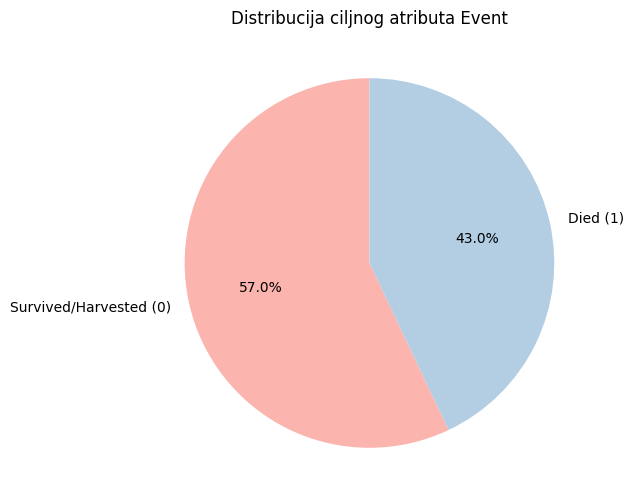

Distribucija klasa:
Event
1.0    1587
0.0    1195
Name: count, dtype: int64


In [25]:
colors = sns.color_palette("Pastel1")
event_counts = data_encoded['Event'].value_counts()

plt.figure(figsize=(8, 6))
event_counts.plot.pie(autopct='%1.1f%%', startangle=90, colors=colors, labels=['Survived/Harvested (0)', 'Died (1)'])
plt.title('Distribucija ciljnog atributa Event')
plt.ylabel('')
plt.show()

print(f"Distribucija klasa:\n{event_counts}")

### Prikaz histograma za numeričke atribute

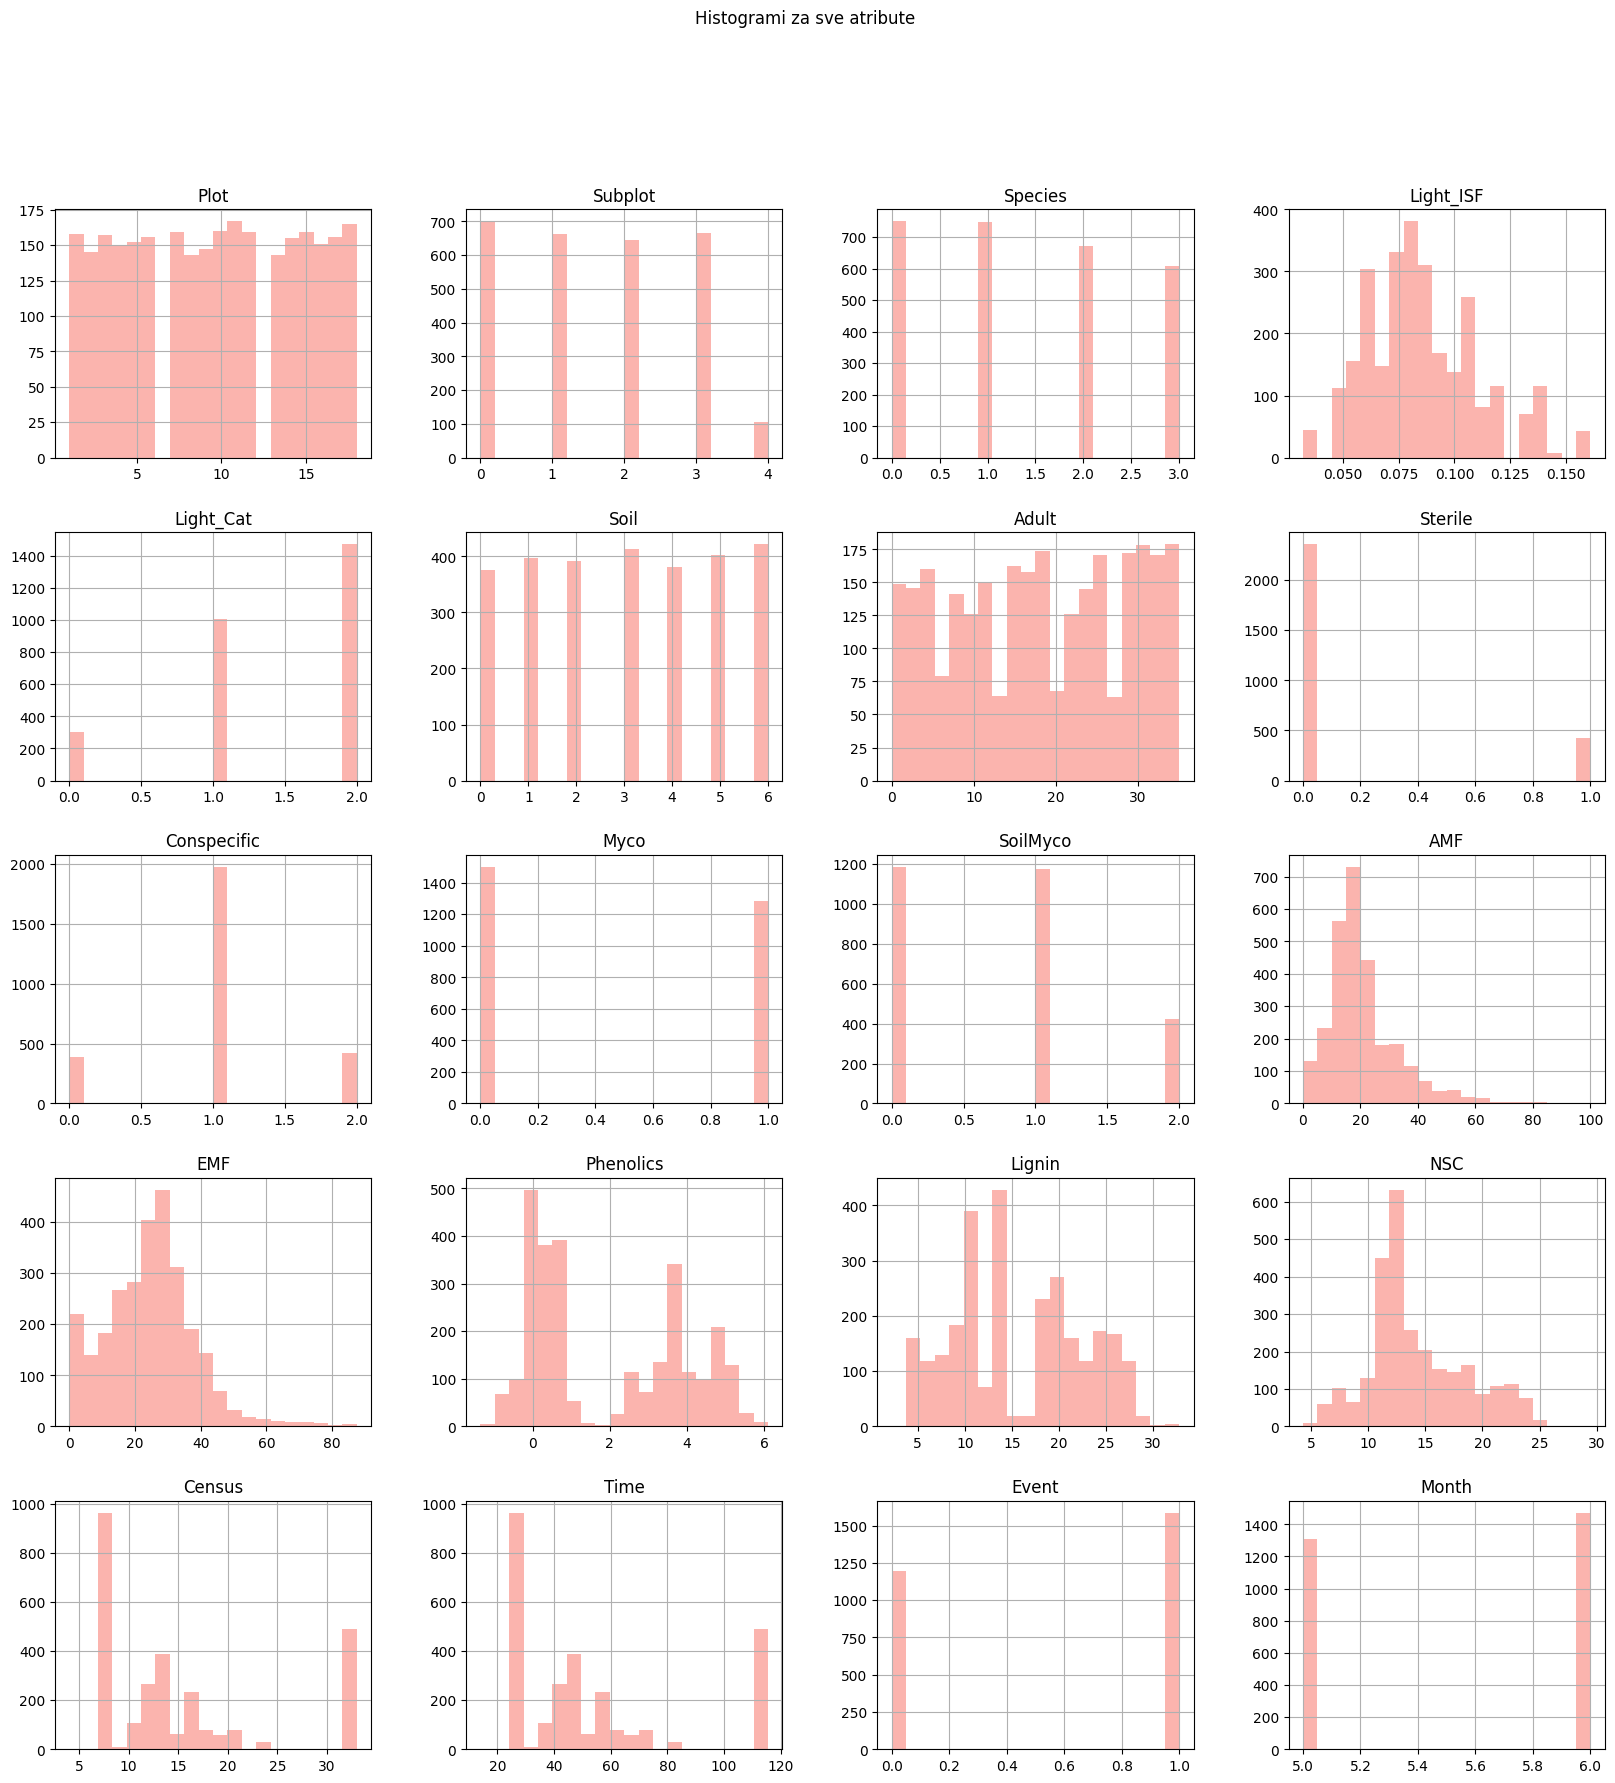

In [26]:
data_encoded.hist(figsize=(20, 20), bins=20, color=colors[0])
plt.suptitle('Histogrami za sve atribute')
plt.show()

### Prikaz matrice korelacije

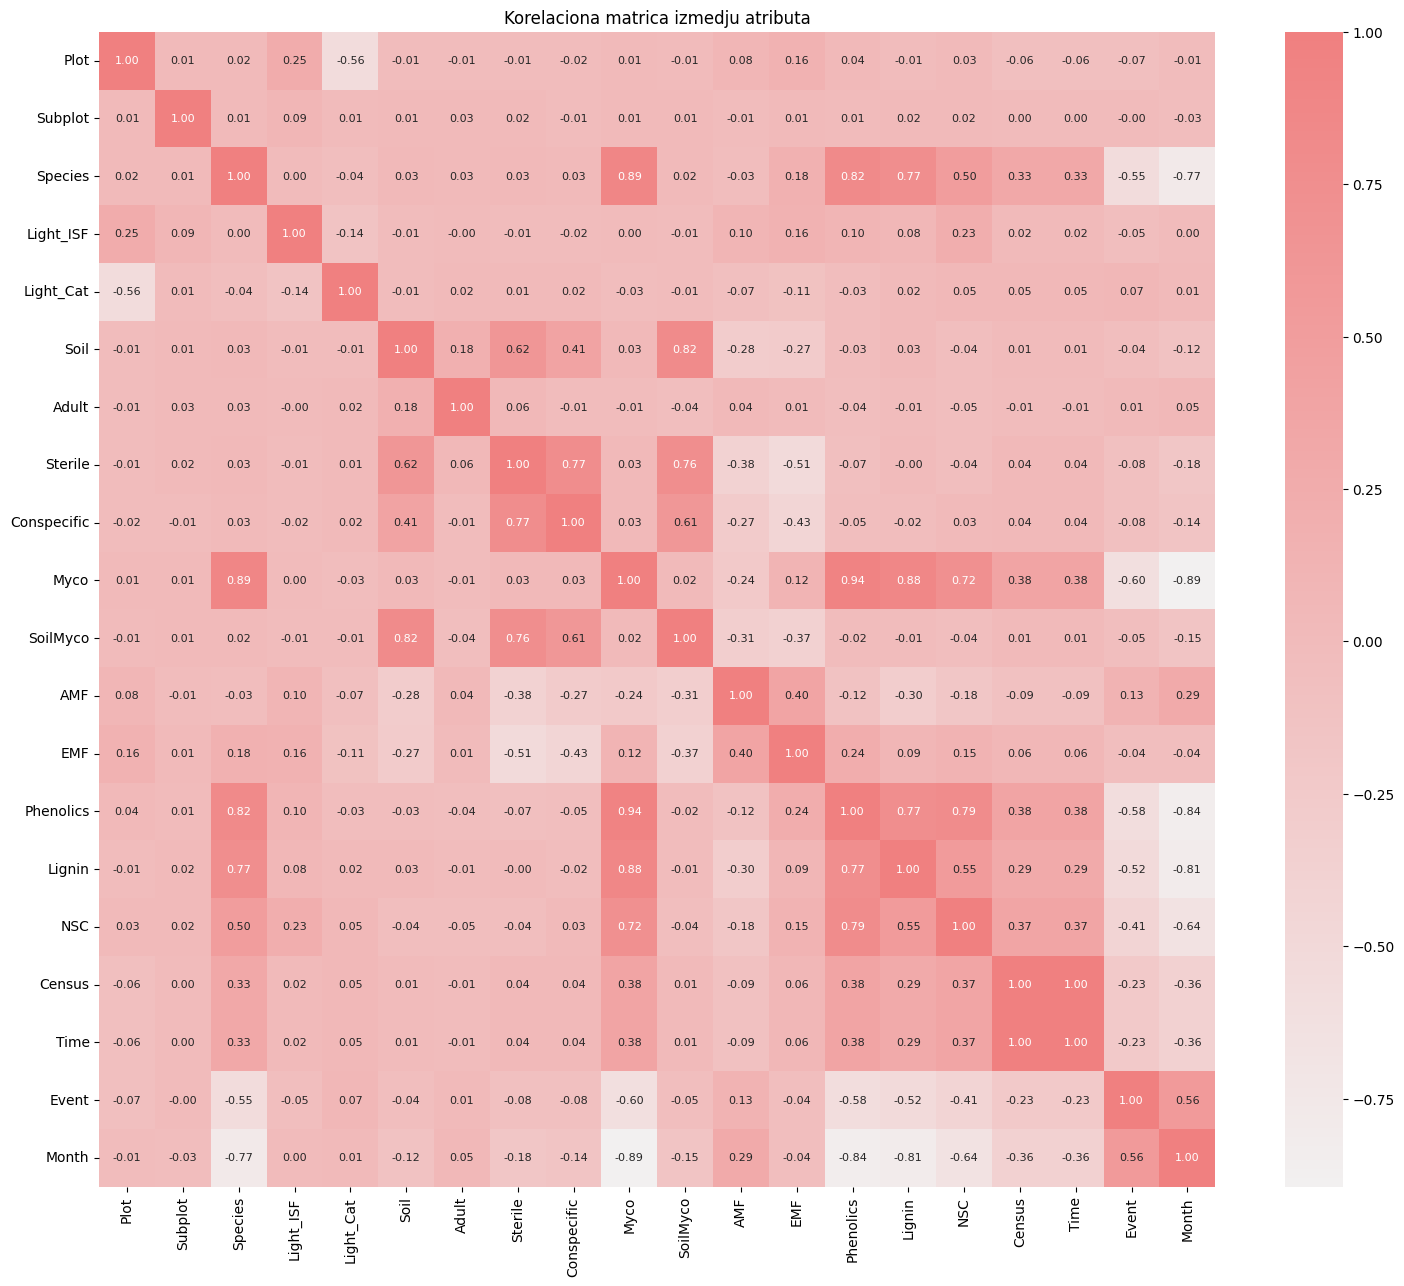

In [27]:
cmap = sns.light_palette("lightcoral", as_cmap=True)
plt.figure(figsize=(18, 15))
hm_correlation = data_encoded.corr()
sns.heatmap(hm_correlation, annot=True, cmap=cmap, fmt='.2f', annot_kws={"size": 8})
plt.title('Korelaciona matrica izmedju atributa')
plt.show()

### Izdvajanje atributa koristeći Mutual Information i ExtraTreesClassifier

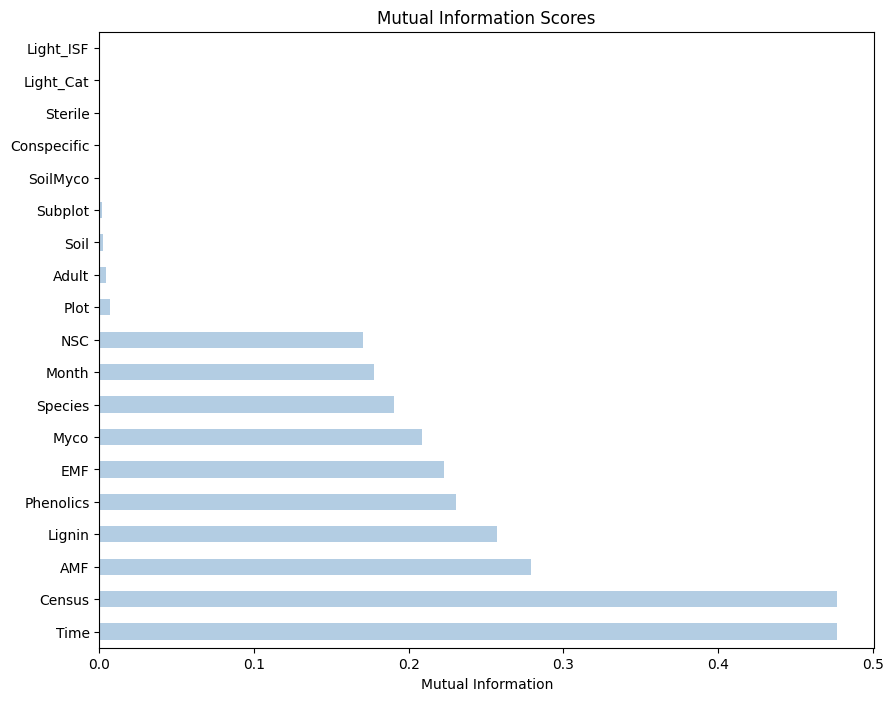

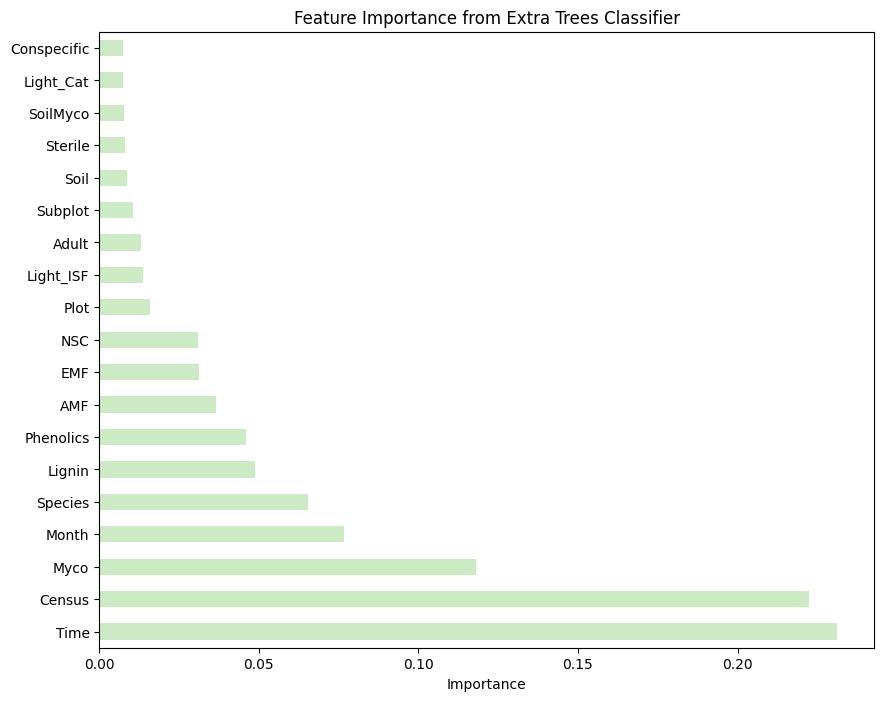

Konačno odabrani atributi: ['EMF', 'Species', 'Myco', 'Time', 'Census', 'AMF', 'Lignin', 'Month', 'NSC', 'Phenolics']
Broj odabranih atributa: 10


In [28]:
X = data_cleaned.drop(columns=['Event'])
y = data_cleaned['Event']

# Mutual Information
mi_scores = mutual_info_classif(X, y, random_state=42)
mi_series = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 8))
mi_series.plot(kind='barh', color=colors[1])
plt.title('Mutual Information Scores')
plt.xlabel('Mutual Information')
plt.show()

# Extra Trees Classifier for Feature Importance
et_model = ExtraTreesClassifier(n_estimators=200, random_state=42)
et_model.fit(X, y)
feat_importances = pd.Series(et_model.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 8))
feat_importances.plot(kind='barh', color=colors[2])
plt.title('Feature Importance from Extra Trees Classifier')
plt.xlabel('Importance')
plt.show()

top_mi_10 = mi_series.nlargest(10).index.tolist()
top_et_10 = feat_importances.nlargest(10).index.tolist()

selected_features = list(set(top_mi_10).union(set(top_et_10)))

print("Konačno odabrani atributi:", selected_features)
print("Broj odabranih atributa:", len(selected_features))

X_selected = X[selected_features]

### Definisanje modela i funkcije za evaluaciju

In [29]:
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, solver='lbfgs'),
    "KNN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "SVM (RBF)": SVC(kernel='rbf', probability=True, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

def evaluate_models(X, y, models, sampler=None):
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    summary_results = []

    for name, model in models.items():
        steps = []
        if sampler is not None:
            # SMOTE (Synthetic Minority Over-sampling Technique) se koristi za rešavanje problema nebalansiranih klasa.
            # On sintetički generiše nove uzorke za manjinsku klasu, čime se postiže balans i sprečava da model bude pristrasan prema većinskoj klasi.
            steps.append(("sampler", sampler))
        steps.append(("scaler", StandardScaler()))
        steps.append(("classifier", model))
        pipeline = Pipeline(steps)

        y_pred = cross_val_predict(pipeline, X, y, cv=kf, n_jobs=-1)
        report = classification_report(y, y_pred, output_dict=True)

        summary_results.append({
            "Model": name,
            "Accuracy": f"{report['accuracy'] * 100:.2f}%",
            "Precision (Macro)": report['macro avg']['precision'],
            "Recall (Macro)": report['macro avg']['recall'],
            "F1-Score (Macro)": report['macro avg']['f1-score']
        })
    
    df_summary = pd.DataFrame(summary_results)
    return df_summary

### Testiranje modela nad originalnim i selektovanim atributima, sa i bez balansiranja

In [30]:
print("--- Rezultati za sve atribute, bez balansiranja ---")
summary_full_none = evaluate_models(X, y, models, sampler=None)
display(summary_full_none)

print("\n--- Rezultati za sve atribute, sa SMOTE ---")
summary_full_smote = evaluate_models(X, y, models, sampler=SMOTE(random_state=42))
display(summary_full_smote)

print("\n--- Rezultati za selektovane atribute, bez balansiranja ---")
summary_selected_none = evaluate_models(X_selected, y, models, sampler=None)
display(summary_selected_none)

print("\n--- Rezultati za selektovane atribute, sa SMOTE ---")
summary_selected_smote = evaluate_models(X_selected, y, models, sampler=SMOTE(random_state=42))
display(summary_selected_smote)

--- Rezultati za sve atribute, bez balansiranja ---


,Model,Accuracy,Precision (Macro),Recall (Macro),F1-Score (Macro)
0,Random Forest,96.59%,0.965510,0.964297,0.964889
1,Decision Tree,95.41%,0.953396,0.951973,0.952664
2,Logistic Regression,80.07%,0.795255,0.800673,0.797036
3,KNN,90.52%,0.914189,0.892745,0.900167
4,Naive Bayes,81.14%,0.807254,0.814720,0.808824
5,SVM (RBF),94.29%,0.944871,0.937736,0.940855
6,XGBoost,96.22%,0.961930,0.960231,0.961052



--- Rezultati za sve atribute, sa SMOTE ---


,Model,Accuracy,Precision (Macro),Recall (Macro),F1-Score (Macro)
0,Random Forest,96.52%,0.964509,0.963790,0.964144
1,Decision Tree,95.07%,0.950369,0.948097,0.949181
2,Logistic Regression,80.51%,0.800260,0.806776,0.802027
3,KNN,90.14%,0.903667,0.893137,0.897383
4,Naive Bayes,81.14%,0.807254,0.814720,0.808824
5,SVM (RBF),94.33%,0.944870,0.938436,0.941281
6,XGBoost,96.41%,0.963422,0.962583,0.962995



--- Rezultati za selektovane atribute, bez balansiranja ---


,Model,Accuracy,Precision (Macro),Recall (Macro),F1-Score (Macro)
0,Random Forest,97.11%,0.971240,0.969251,0.970208
1,Decision Tree,95.63%,0.956305,0.953623,0.954895
2,Logistic Regression,80.18%,0.796595,0.802517,0.798388
3,KNN,94.33%,0.944568,0.938691,0.941314
4,Naive Bayes,81.29%,0.808617,0.815990,0.810260
5,SVM (RBF),94.22%,0.944913,0.936337,0.939999
6,XGBoost,96.37%,0.963217,0.962010,0.962599



--- Rezultati za selektovane atribute, sa SMOTE ---


,Model,Accuracy,Precision (Macro),Recall (Macro),F1-Score (Macro)
0,Random Forest,96.85%,0.968004,0.967156,0.967573
1,Decision Tree,95.63%,0.956178,0.953750,0.954907
2,Logistic Regression,80.55%,0.800558,0.806966,0.802347
3,KNN,94.59%,0.945819,0.942696,0.944162
4,Naive Bayes,81.29%,0.808617,0.815990,0.810260
5,SVM (RBF),94.33%,0.944421,0.938818,0.941331
6,XGBoost,96.29%,0.962334,0.961375,0.961846


### Optimizacija Hiperparametara za najbolje modele


=== RF (Optimizovan) ===
Najbolji parametri: {'rf__max_depth': 20, 'rf__min_samples_split': 2, 'rf__n_estimators': 200}

Classification Report na Test setu:
              precision    recall  f1-score   support

         0.0       0.96      0.95      0.96       225
         1.0       0.97      0.97      0.97       315

    accuracy                           0.96       540
   macro avg       0.96      0.96      0.96       540
weighted avg       0.96      0.96      0.96       540



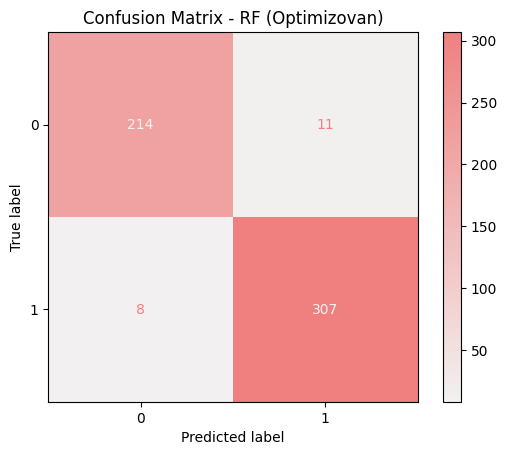


=== XGB (Optimizovan) ===
Najbolji parametri: {'xgb__learning_rate': 0.1, 'xgb__max_depth': 5, 'xgb__n_estimators': 200}

Classification Report na Test setu:
              precision    recall  f1-score   support

         0.0       0.97      0.93      0.95       225
         1.0       0.95      0.98      0.97       315

    accuracy                           0.96       540
   macro avg       0.96      0.96      0.96       540
weighted avg       0.96      0.96      0.96       540



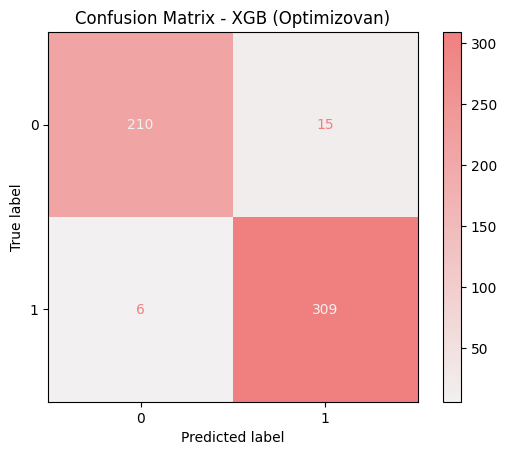

In [31]:
models_params = {
    "rf": {
        "model": RandomForestClassifier(random_state=42),
        "param_grid": {
            'rf__n_estimators': [100, 200],
            'rf__max_depth': [10, 20, None],
            'rf__min_samples_split': [2, 5]
        }
    },
    "xgb": {
        "model": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
        "param_grid": {
            'xgb__n_estimators': [100, 200],
            'xgb__max_depth': [3, 5, 7],
            'xgb__learning_rate': [0.01, 0.1]
        }
    }
}

X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, stratify=y, random_state=42)

for name, mp in models_params.items():
    pipeline = Pipeline([
        ('smote', SMOTE(random_state=42)),
        ('scaler', StandardScaler()),
        (name, mp['model'])
    ])

    grid_search = GridSearchCV(pipeline, param_grid=mp['param_grid'], cv=5, scoring='f1_macro', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    
    print(f"\n=== {name.upper()} (Optimizovan) ===")
    print("Najbolji parametri:", grid_search.best_params_)
    print("\nClassification Report na Test setu:")
    print(classification_report(y_test, y_pred))
    
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=cmap)
    plt.title(f"Confusion Matrix - {name.upper()} (Optimizovan)")
    plt.show()

### Zaključak

In [32]:
print("Uporedni prikaz performansi modela nakon optimizacije:\n")

print("--- Rezultati za selektovane atribute, sa SMOTE (pre optimizacije) ---")
display(summary_selected_smote)

print("\nNakon optimizacije hiperparametara, vide se poboljšanja u performansama, posebno u F1-skoru koji je ključan za nebalansirane setove podataka.")
print("Random Forest i XGBoost su se pokazali kao najuspešniji modeli.")

print("\nFinalni izveštaj za optimizovani Random Forest:")

best_rf_pipeline = grid_search.best_estimator_ 
y_pred_final = best_rf_pipeline.predict(X_test)
print(classification_report(y_test, y_pred_final))

Uporedni prikaz performansi modela nakon optimizacije:

--- Rezultati za selektovane atribute, sa SMOTE (pre optimizacije) ---


,Model,Accuracy,Precision (Macro),Recall (Macro),F1-Score (Macro)
0,Random Forest,96.85%,0.968004,0.967156,0.967573
1,Decision Tree,95.63%,0.956178,0.953750,0.954907
2,Logistic Regression,80.55%,0.800558,0.806966,0.802347
3,KNN,94.59%,0.945819,0.942696,0.944162
4,Naive Bayes,81.29%,0.808617,0.815990,0.810260
5,SVM (RBF),94.33%,0.944421,0.938818,0.941331
6,XGBoost,96.29%,0.962334,0.961375,0.961846



Nakon optimizacije hiperparametara, vide se poboljšanja u performansama, posebno u F1-skoru koji je ključan za nebalansirane setove podataka.
Random Forest i XGBoost su se pokazali kao najuspešniji modeli.

Finalni izveštaj za optimizovani Random Forest:
              precision    recall  f1-score   support

         0.0       0.97      0.93      0.95       225
         1.0       0.95      0.98      0.97       315

    accuracy                           0.96       540
   macro avg       0.96      0.96      0.96       540
weighted avg       0.96      0.96      0.96       540

